# EDA and Preliminary Modeling

This notebook contains basic EDA and some preliminary modeling of the data. It is separated into the following sections:

* [Cleaning](#Cleaning)<a href='#Cleaning'>
    
* [Target Grid Search](#TGS)<a href='#TGS'>
    
* [Binning & EDA](#beda)<a href='#beda'>
    
* [CountVectorizer](#cv)<a href='#cv'>
    
* [Tf-idf](#tf)<a href='#tf'>
    
* [LDA](#LDA)<a href='#LDA'>
    
* [Vader](#Vader)<a href='#Vader'>

* [Modeling](#Modeling)<a href='#Modeling'>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import altair as alt
import pickle
import warnings
warnings.filterwarnings('ignore') #Silence future warnings during optimization function

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import altair as alt
alt.renderers.enable('notebook')

import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from pandas.io.json import json_normalize
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, jaccard_score, hamming_loss
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import SMOTE

/Users/kristigourlay/anaconda3/lib/python3.7/site-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable
/Users/kristigourlay/anaconda3/lib/python3.7/site-packages/nltk/decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""
/Users/kristigourlay/anaconda3/lib/python3.7/site-packages/nltk/lm/counter.py:15: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence, defaultdict
Using TensorFlow backend.
/Users/kristigourlay/anaconda3/lib/python3.7/site-packages/google/protobuf/descriptor.py:47: DeprecationWarning: Using or importing the ABCs from 'collections

In [2]:
df = pd.read_csv('../data/processed/final_book_df.csv', index_col=0)

In [3]:
df2 = pd.read_csv('../data/processed/reddit_df_with_dates.csv', index_col=0)

In [4]:
df2 = df2.drop(columns=['duck_dates', 'ask_dates'])
df = df.append(df2)

In [5]:
df = df.reset_index()
df = df.drop(columns=['index'])

In [6]:
df.describe()

,date,target
count,1158.000000,1022.000000
mean,1855.466321,2.529354
std,125.959715,1.738716
min,1511.000000,0.000000
25%,1800.000000,1.000000
50%,1898.000000,2.000000
75%,1939.000000,4.000000
max,2016.000000,5.000000


In [7]:
df = df.drop_duplicates(subset=['text'], keep='first', inplace=False)

In [8]:
df['date'] = df['date'].astype(int)

In [9]:
df.shape

(1097, 4)

In [10]:
df.isna().sum()

date        0
info        2
target    136
text        0
dtype: int64

In [11]:
df.head(2)

,date,info,target,text
0,1528,The book of the Courtier,0.0,then the soul freed from vice purged by studie...
1,1569,Hamlet,0.0,his goodly frame the earth seems to me a steri...


In [252]:
# df.to_csv('../data/cleaned/concat_df.csv')

# Clean Text
<a id='Cleaning'></a>

In [13]:
from sklearn.base import TransformerMixin

class LanguageTransformer(TransformerMixin):

    def fit(self, raw_text):
        return self

    def clean_text(self, raw_text):
       
        raw_text = str(raw_text)
        lower_case = raw_text.lower()
        retokenizer = RegexpTokenizer(r'[a-z]+')
        words = retokenizer.tokenize(lower_case)
        new_words = " ".join(words)
        return new_words

    def lemm(self, new_words):
        lemmatizer = WordNetLemmatizer()

        final_sentences = []
        for line in new_words:
            line = str(line)
            line = line.split()
            new_sentence = []
            for word in line:
                new_word = lemmatizer.lemmatize(word)
                new_sentence.append(new_word)
            final_sentences.append(new_sentence)
            
        return final_sentences

In [14]:
ct = LanguageTransformer()
ct.fit(df['text'])
df['text'] = df['text'].apply(ct.clean_text)
df['text'] = ct.lemm(df['text'])

# Function to Grid Search Target Dates
<a id='TGS'></a>

In [17]:
bin_list = [
    [0, 1670, 1800, 1870, 1910, 1945, np.inf],
    [0, 1670, 1830, 1870, 1910, 1945, np.inf],
    [0, 1670, 1830, 1870, 1920, 1945, np.inf],
    [0, 1670, 1800, 1870, 1920, 1945, np.inf],
    [0, 1670, 1830, 1890, 1920, 1945, np.inf],
    [0, 1670, 1830, 1890, 1920, 1950, np.inf],
    [0, 1670, 1830, 1890, 1910, 1945, np.inf],
    [0, 1700, 1800, 1870, 1910, 1945, np.inf],
    [0, 1700, 1830, 1890, 1910, 1945, np.inf],
    [0, 1700, 1830, 1870, 1920, 1945, np.inf],
    [0, 1600, 1700, 1800, 1900, 1950, np.inf],
    [0, 1700, 1830, 1890, 1910, 1945, np.inf],
    [0, 1670, 1830, 1890, 1920, 1960, np.inf]
]

In [18]:
cvec = CountVectorizer(stop_words='english',
                        lowercase=True,
                        ngram_range=(1, 2),
                        strip_accents='unicode')

tvec = TfidfVectorizer(stop_words='english',
                        ngram_range=(1, 3),
                        encoding='utf-8')

In [19]:
def make_targets(bin_list, model, vectorizer, df=df):
    
    '''
    Function to grid search and find the optimal target for time periods
    bin_list: several ways to classify the targets
    model: model to instantiate
    vectorizer: either bag of words or tf-idf
    '''
    
    for b in bin_list:
        bins = b
        bin_names = range(0, 6)
        df['target'] = pd.cut(df['date'], bins, labels=bin_names)
        df.groupby('target').count()

        #split data
        x = df['text']
        y = df['target']
        x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=.8, random_state=42, shuffle=True, stratify=y)
        
        
        #vectorizing
        train_data = vectorizer.fit_transform(x_train.apply(lambda x: np.str_(x)))
        test_data = vectorizer.transform(x_test.apply(lambda x: np.str_(x)))
        
       
        
        #instantiating, fitting, and scoring the model
        model = model
        model.fit(train_data, y_train)
        score = model.score(test_data, y_test)
       
        print(f' Test Accuracy of Bin {bins}: {score}')

In [20]:
make_targets(bin_list, model=LogisticRegression(solver='lbfgs', class_weight='balanced', multi_class='multinomial'), vectorizer=cvec)

 Test Accuracy of Bin [0, 1670, 1800, 1870, 1910, 1945, inf]: 0.6954545454545454
 Test Accuracy of Bin [0, 1670, 1830, 1870, 1910, 1945, inf]: 0.6954545454545454
 Test Accuracy of Bin [0, 1670, 1830, 1870, 1920, 1945, inf]: 0.6590909090909091
 Test Accuracy of Bin [0, 1670, 1800, 1870, 1920, 1945, inf]: 0.6863636363636364
 Test Accuracy of Bin [0, 1670, 1830, 1890, 1920, 1945, inf]: 0.7090909090909091
 Test Accuracy of Bin [0, 1670, 1830, 1890, 1920, 1950, inf]: 0.7090909090909091
 Test Accuracy of Bin [0, 1670, 1830, 1890, 1910, 1945, inf]: 0.6818181818181818
 Test Accuracy of Bin [0, 1700, 1800, 1870, 1910, 1945, inf]: 0.7
 Test Accuracy of Bin [0, 1700, 1830, 1890, 1910, 1945, inf]: 0.6681818181818182
 Test Accuracy of Bin [0, 1700, 1830, 1870, 1920, 1945, inf]: 0.6363636363636364
 Test Accuracy of Bin [0, 1600, 1700, 1800, 1900, 1950, inf]: 0.6818181818181818
 Test Accuracy of Bin [0, 1700, 1830, 1890, 1910, 1945, inf]: 0.6681818181818182
 Test Accuracy of Bin [0, 1670, 1830, 1890,

In [21]:
make_targets(bin_list, model=RandomForestClassifier(), vectorizer=cvec) 

 Test Accuracy of Bin [0, 1670, 1800, 1870, 1910, 1945, inf]: 0.5590909090909091
 Test Accuracy of Bin [0, 1670, 1830, 1870, 1910, 1945, inf]: 0.5636363636363636
 Test Accuracy of Bin [0, 1670, 1830, 1870, 1920, 1945, inf]: 0.5227272727272727
 Test Accuracy of Bin [0, 1670, 1800, 1870, 1920, 1945, inf]: 0.5272727272727272
 Test Accuracy of Bin [0, 1670, 1830, 1890, 1920, 1945, inf]: 0.5318181818181819
 Test Accuracy of Bin [0, 1670, 1830, 1890, 1920, 1950, inf]: 0.55
 Test Accuracy of Bin [0, 1670, 1830, 1890, 1910, 1945, inf]: 0.5545454545454546
 Test Accuracy of Bin [0, 1700, 1800, 1870, 1910, 1945, inf]: 0.55
 Test Accuracy of Bin [0, 1700, 1830, 1890, 1910, 1945, inf]: 0.5636363636363636
 Test Accuracy of Bin [0, 1700, 1830, 1870, 1920, 1945, inf]: 0.5954545454545455
 Test Accuracy of Bin [0, 1600, 1700, 1800, 1900, 1950, inf]: 0.5227272727272727
 Test Accuracy of Bin [0, 1700, 1830, 1890, 1910, 1945, inf]: 0.5545454545454546
 Test Accuracy of Bin [0, 1670, 1830, 1890, 1920, 1960, 

In [22]:
make_targets(bin_list, model=RandomForestClassifier(), vectorizer=tvec)

 Test Accuracy of Bin [0, 1670, 1800, 1870, 1910, 1945, inf]: 0.5727272727272728
 Test Accuracy of Bin [0, 1670, 1830, 1870, 1910, 1945, inf]: 0.5318181818181819
 Test Accuracy of Bin [0, 1670, 1830, 1870, 1920, 1945, inf]: 0.5681818181818182
 Test Accuracy of Bin [0, 1670, 1800, 1870, 1920, 1945, inf]: 0.5318181818181819
 Test Accuracy of Bin [0, 1670, 1830, 1890, 1920, 1945, inf]: 0.5363636363636364
 Test Accuracy of Bin [0, 1670, 1830, 1890, 1920, 1950, inf]: 0.5636363636363636
 Test Accuracy of Bin [0, 1670, 1830, 1890, 1910, 1945, inf]: 0.5545454545454546
 Test Accuracy of Bin [0, 1700, 1800, 1870, 1910, 1945, inf]: 0.5272727272727272
 Test Accuracy of Bin [0, 1700, 1830, 1890, 1910, 1945, inf]: 0.55
 Test Accuracy of Bin [0, 1700, 1830, 1870, 1920, 1945, inf]: 0.509090909090909
 Test Accuracy of Bin [0, 1600, 1700, 1800, 1900, 1950, inf]: 0.5409090909090909
 Test Accuracy of Bin [0, 1700, 1830, 1890, 1910, 1945, inf]: 0.5409090909090909
 Test Accuracy of Bin [0, 1670, 1830, 1890,

In [23]:
make_targets(bin_list, model=LogisticRegression(solver='lbfgs', class_weight='balanced', multi_class='multinomial'), vectorizer=tvec)

 Test Accuracy of Bin [0, 1670, 1800, 1870, 1910, 1945, inf]: 0.7090909090909091
 Test Accuracy of Bin [0, 1670, 1830, 1870, 1910, 1945, inf]: 0.6863636363636364
 Test Accuracy of Bin [0, 1670, 1830, 1870, 1920, 1945, inf]: 0.65
 Test Accuracy of Bin [0, 1670, 1800, 1870, 1920, 1945, inf]: 0.6863636363636364
 Test Accuracy of Bin [0, 1670, 1830, 1890, 1920, 1945, inf]: 0.6909090909090909
 Test Accuracy of Bin [0, 1670, 1830, 1890, 1920, 1950, inf]: 0.7
 Test Accuracy of Bin [0, 1670, 1830, 1890, 1910, 1945, inf]: 0.6863636363636364
 Test Accuracy of Bin [0, 1700, 1800, 1870, 1910, 1945, inf]: 0.6863636363636364
 Test Accuracy of Bin [0, 1700, 1830, 1890, 1910, 1945, inf]: 0.6545454545454545
 Test Accuracy of Bin [0, 1700, 1830, 1870, 1920, 1945, inf]: 0.65
 Test Accuracy of Bin [0, 1600, 1700, 1800, 1900, 1950, inf]: 0.65
 Test Accuracy of Bin [0, 1700, 1830, 1890, 1910, 1945, inf]: 0.6545454545454545
 Test Accuracy of Bin [0, 1670, 1830, 1890, 1920, 1960, inf]: 0.6863636363636364


# Binning & EDA
<a id='beda'></a>

In [24]:
bins = [0, 1670, 1830, 1890, 1920, 1950, np.inf] #Performed well on all
names = [0, 1, 2, 3, 4, 5]

df['target'] = pd.cut(df['date'], bins, labels=names)

df.groupby('target').count()

,date,info,text
target,,,
0,149,148,149
1,163,163,163
2,196,196,196
3,148,148,148
4,172,172,172
5,269,268,269


In [25]:
df.shape

(1097, 4)

In [37]:
df.head(2)

,date,info,target,text
0,1528,The book of the Courtier,0,"['then', 'the', 'soul', 'freed', 'from', 'vice..."
1,1569,Hamlet,0,"['his', 'goodly', 'frame', 'the', 'earth', 'se..."


In [27]:
df.isna().sum()

date      0
info      2
target    0
text      0
dtype: int64

In [28]:
df.dtypes

date         int64
info        object
target    category
text        object
dtype: object

In [33]:
df.target = df.target.astype(int)
df.text = df.text.astype(str)

In [34]:
# df.to_csv('../data/cleaned/book_df.csv')

# Countvectorizer Unigrams
<a id='cv'></a>

In [61]:
stop = stopwords.words('english')
stop.extend(['one', 'word', 'us', 'could', 'look', 'back', 'wa', 'rollo', 'thing', 'things', 'man', 'go', 'let', 'see', 'would', 'two', 'time', 'said', 'panhandle', 'made', 'every', 'little', 'brutus', 'dryden']) 

In [62]:
cvec = CountVectorizer(stop_words=stop)
unigrams = pd.DataFrame(cvec.fit_transform(df['text']).todense(), columns=cvec.get_feature_names())
unigrams['target'] = df['target']

In [63]:
target0_top_uni = unigrams.groupby('target').sum().T.sort_values(by=0, ascending=False)[[0]].head(20)
target1_top_uni = unigrams.groupby('target').sum().T.sort_values(by=1, ascending=False)[[0]].head(20)
target2_top_uni = unigrams.groupby('target').sum().T.sort_values(by=2, ascending=False)[[0]].head(20)
target3_top_uni = unigrams.groupby('target').sum().T.sort_values(by=3, ascending=False)[[0]].head(20)
target4_top_uni = unigrams.groupby('target').sum().T.sort_values(by=4, ascending=False)[[0]].head(20)
target5_top_uni = unigrams.groupby('target').sum().T.sort_values(by=5, ascending=False)[[0]].head(20)

In [64]:
def clean_gram_df(uni_df):
    unigram_df = uni_df.rename(columns={0: 'frequency'})
    unigram_df = unigram_df.reset_index()
    unigram_df = unigram_df.rename(columns={'index': 'word'})
    return unigram_df

In [65]:
# using the clean_uni_df function to create individual dataframes for each target

target0 = clean_gram_df(target0_top_uni)
target1 = clean_gram_df(target1_top_uni)
target2 = clean_gram_df(target2_top_uni)
target3 = clean_gram_df(target3_top_uni)
target4 = clean_gram_df(target4_top_uni)
target5 = clean_gram_df(target5_top_uni)

In [66]:
def altair_chart(target, color='darkred'):
    '''
    Input: target dataframe and color
    Output: altair chart
    '''
    
    Chart = alt.Chart(target).mark_bar(color=color).encode(
        x='word',
        y='frequency')
    
    return Chart

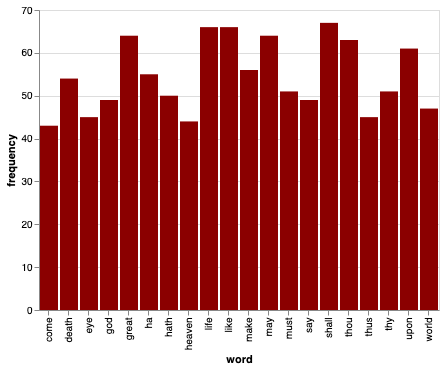

In [67]:
altair_chart(target0)

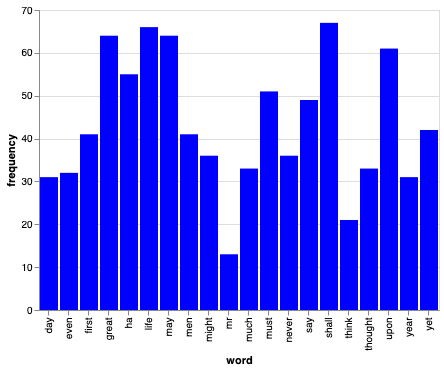

In [68]:
altair_chart(target1, color='blue')

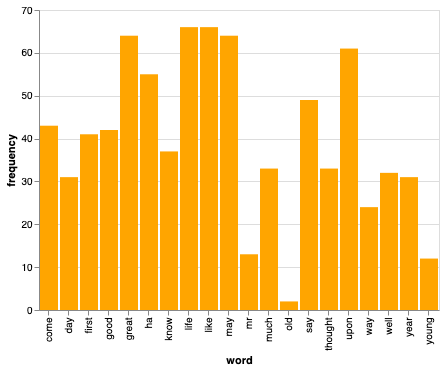

In [69]:
altair_chart(target2, color='orange')

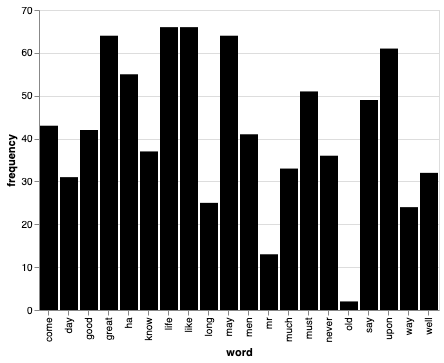

In [70]:
altair_chart(target3, color='black')

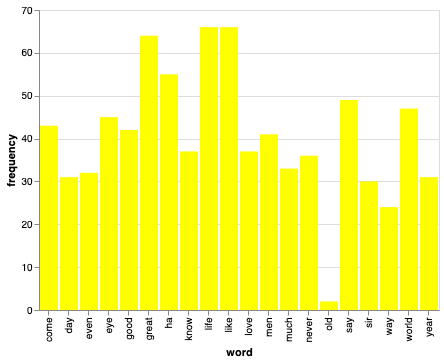

In [71]:
altair_chart(target4, color='yellow')

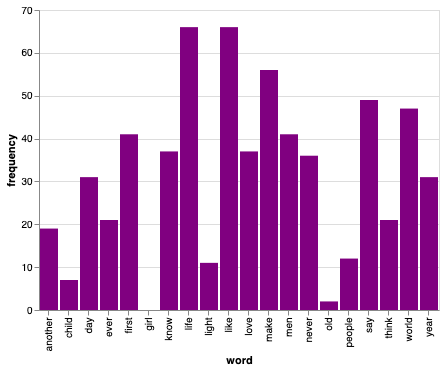

In [72]:
altair_chart(target5, color='purple')

In [ ]:
# Because the dataset is so small, there is not enough data to find any insight with bigrams.

# Inverse Document Frequency (Tf-idf)
<a id='tf'></a>

In [78]:
tvec = TfidfVectorizer(stop_words=stop,
                        ngram_range=(1, 3),
                        encoding='utf-8')

tvec_unigrams = pd.DataFrame(tvec.fit_transform(df['text']).todense(), columns=tvec.get_feature_names())
tvec_unigrams['target'] = df['target']

In [79]:
target0_top_uni = tvec_unigrams.groupby('target').sum().T.sort_values(by=0, ascending=False)[[0]].head(5)
target1_top_uni = tvec_unigrams.groupby('target').sum().T.sort_values(by=1, ascending=False)[[0]].head(5)
target2_top_uni = tvec_unigrams.groupby('target').sum().T.sort_values(by=2, ascending=False)[[0]].head(5)
target3_top_uni = tvec_unigrams.groupby('target').sum().T.sort_values(by=3, ascending=False)[[0]].head(5)
target4_top_uni = tvec_unigrams.groupby('target').sum().T.sort_values(by=4, ascending=False)[[0]].head(5)
target5_top_uni = tvec_unigrams.groupby('target').sum().T.sort_values(by=5, ascending=False)[[0]].head(5)

In [80]:
t0 = clean_gram_df(target0_top_uni)
t1 = clean_gram_df(target1_top_uni)
t2 = clean_gram_df(target2_top_uni)
t3 = clean_gram_df(target3_top_uni)
t4 = clean_gram_df(target4_top_uni)
t5 = clean_gram_df(target5_top_uni)

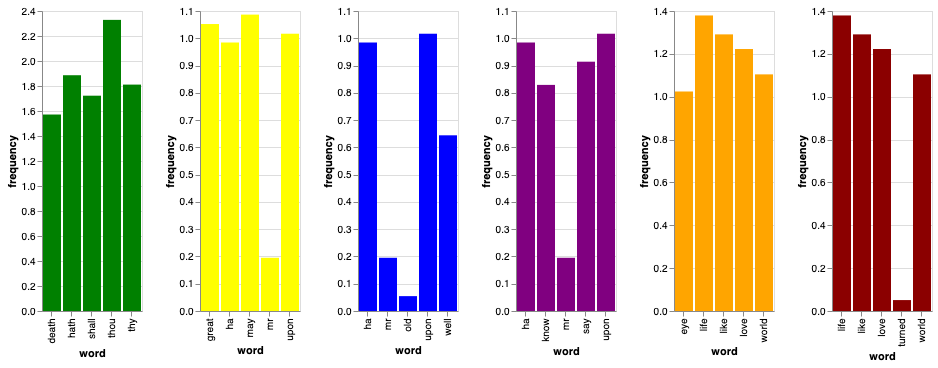

In [81]:
ChartA = altair_chart(t0, color='green')
ChartB = altair_chart(t1, color='yellow')
ChartC = altair_chart(t2, color='blue')
ChartD = altair_chart(t3, color='purple')
ChartE = altair_chart(t4, color='orange')
ChartF = altair_chart(t5)

ChartA | ChartB | ChartC | ChartD | ChartE | ChartF

# LDA
<a id='LDA'></a>

In [82]:
target0 = df[df.target == 0]['text']
target1 = df[df.target == 1]['text']
target2 = df[df.target == 2]['text']
target3 = df[df.target == 3]['text']
target4 = df[df.target == 4]['text']
target5 = df[df.target == 5]['text']

In [83]:
def LDA_graph(target_group):
    
    lda = LDA(n_components=3, random_state=42)
    t = cvec.fit_transform(target_group)
    lda_t = lda.fit_transform(t)
    
    return pyLDAvis.sklearn.prepare(lda, t, cvec)

In [84]:
LDA_graph(target0)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.080225  0.098512       1        1  34.472382
1     -0.060174 -0.108360       2        1  33.053413
2      0.140399  0.009848       3        1  32.474204, topic_info=     Category       Freq         Term      Total  loglift  logprob
3005  Default  18.000000         poet  18.000000  30.0000  30.0000
2361  Default  28.000000         love  28.000000  29.0000  29.0000
128   Default  21.000000       always  21.000000  28.0000  28.0000
3806  Default  12.000000        stage  12.000000  27.0000  27.0000
1428  Default  17.000000        faith  17.000000  26.0000  26.0000
3659  Default  22.000000          sir  22.000000  25.0000  25.0000
3428  Default  15.000000        royal  15.000000  24.0000  24.0000
4485  Default  11.000000       wisdom  11.000000  23.0000  23.0000
656   Default  11.000000       christ  11.000000  22.0000  22.0000
3170  Default  11.000000    purgatory  11.000000  21.0000  21.0000
4195  Default  10.000000       twenty  10.000000  20.0000  20.0000
1344  Default  26.000000         even  26.000000  19.0000  19.0000
3009  Default   9.000000       poetry   9.000000  18.0000  18.0000
2678  Default  21.000000          new  21.000000  17.0000  17.0000
3713  Default  16.000000      society  16.000000  16.0000  16.0000
371   Default   9.000000      besides   9.000000  15.0000  15.0000
2264  Default  12.000000        least  12.000000  14.0000  14.0000
1477  Default   9.000000      feeling   9.000000  13.0000  13.0000
1908  Default   9.000000      highest   9.000000  12.0000  12.0000
1534  Default   9.000000         flat   9.000000  11.0000  11.0000
1866  Default  12.000000         heav  12.000000  10.0000  10.0000
2969  Default   9.000000       plague   9.000000   9.0000   9.0000
3496  Default   9.000000          sea   9.000000   8.0000   8.0000
3044  Default  15.000000        power  15.000000   7.0000   7.0000
126   Default  19.000000     although  19.000000   6.0000   6.0000
4456  Default   8.000000      whither   8.000000   5.0000   5.0000
1737  Default  27.000000         good  27.000000   4.0000   4.0000
4047  Default  15.000000        think  15.000000   3.0000   3.0000
1535  Default   8.000000     flatness   8.000000   2.0000   2.0000
2205  Default  10.000000    knowledge  10.000000   1.0000   1.0000
...       ...        ...          ...        ...      ...      ...
128    Topic3  16.755576       always  21.050915   0.8965  -5.6051
2264   Topic3  10.757584        least  12.771547   0.9531  -6.0483
3044   Topic3  12.220124        power  15.781994   0.8689  -5.9208
3659   Topic3  15.925589          sir  22.503789   0.7790  -5.6559
126    Topic3  14.226986     although  19.546171   0.8071  -5.7687
3783   Topic3  13.010489       spirit  18.792945   0.7570  -5.8581
3073   Topic3   7.003099     presence   8.252506   0.9606  -6.4775
4219   Topic3   7.007136  unfortunate   8.262152   0.9600  -6.4769
1704   Topic3   8.509656        gives  11.262714   0.8444  -6.2827
1125   Topic3   9.258915       divine  12.763058   0.8038  -6.1983
4566   Topic3   8.482827        years  11.272572   0.8404  -6.2858
2212   Topic3   9.933957         lady  15.023624   0.7111  -6.1279
2174   Topic3   8.502905         keep  12.023064   0.7783  -6.2835
1443   Topic3  11.507553          far  21.844818   0.4838  -5.9809
4079   Topic3  15.250498          thy  39.827093   0.1648  -5.6993
4525   Topic3  13.757110        world  33.080006   0.2474  -5.8023
1834   Topic3   7.754344       hardly  10.503242   0.8213  -6.3756
715    Topic3   8.516537      command  12.792972   0.7178  -6.2819
1867   Topic3  13.005191       heaven  32.359540   0.2132  -5.8585
4571   Topic3  12.425591          yet  29.324200   0.2661  -5.9041
548    Topic3  11.182360       cannot  24.051750   0.3589  -6.0095
2303   Topic3  15.266372         like  49.764647  -0.0569  -5.6982
2676   Topic3  11.506168        never  26.337732   0.2966  -5.9810
40

In [85]:
LDA_graph(target1)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.040175  0.075261       1        1  45.029995
0     -0.050158 -0.069913       2        1  33.596973
1      0.090333 -0.005348       3        1  21.373032, topic_info=      Category        Freq       Term       Total  loglift  logprob
5815   Default   81.000000        mrs   81.000000  30.0000  30.0000
750    Default   27.000000   bargrave   27.000000  29.0000  29.0000
9592   Default   24.000000       veal   24.000000  28.0000  28.0000
7810   Default   29.000000       says   29.000000  27.0000  27.0000
2174   Default   29.000000         de   29.000000  26.0000  26.0000
6837   Default   28.000000  pretender   28.000000  25.0000  25.0000
8974   Default   32.000000         th   32.000000  24.0000  24.0000
9712   Default   18.000000     voyage   18.000000  23.0000  23.0000
7122   Default   51.000000      queen   51.000000  22.0000  22.0000
5754   Default   11.000000       moon   11.000000  21.0000  21.0000
970    Default   12.000000      blood   12.000000  20.0000  20.0000
7989   Default   10.000000   serjeant   10.000000  19.0000  19.0000
5495   Default   15.000000   mathilda   15.000000  18.0000  18.0000
710    Default   21.000000     badman   21.000000  17.0000  17.0000
7673   Default    9.000000       roul    9.000000  16.0000  16.0000
8822   Default   32.000000      swift   32.000000  15.0000  15.0000
3718   Default   63.000000     french   63.000000  14.0000  14.0000
1608   Default   10.000000    colonel   10.000000  13.0000  13.0000
5178   Default  101.000000       life  101.000000  12.0000  12.0000
8933   Default   35.000000     temple   35.000000  11.0000  11.0000
8194   Default   37.000000        sir   37.000000  10.0000  10.0000
7942   Default   38.000000       seen   38.000000   9.0000   9.0000
1187   Default   18.000000      burke   18.000000   8.0000   8.0000
3381   Default   77.000000     father   77.000000   7.0000   7.0000
3403   Default   20.000000       fear   20.000000   6.0000   6.0000
9666   Default   12.000000     violet   12.000000   5.0000   5.0000
6739   Default   24.000000     pounds   24.000000   4.0000   4.0000
403    Default   49.000000    another   49.000000   3.0000   3.0000
2705   Default   10.000000      dream   10.000000   2.0000   2.0000
8196   Default   16.000000     sister   16.000000   1.0000   1.0000
...        ...         ...        ...         ...      ...      ...
8194    Topic3   15.582356        sir   37.089393   0.6758  -6.3699
403     Topic3   17.576989    another   49.904002   0.4995  -6.2494
5193    Topic3   22.678600       like   92.452577   0.1378  -5.9946
2182    Topic3   11.680171       dear   28.451846   0.6527  -6.6581
5950    Topic3   21.640388      never   93.906583   0.0753  -6.0415
8576    Topic3   14.976223      still   47.910902   0.3802  -6.4096
565     Topic3    8.037503      asked   14.734261   0.9370  -7.0319
4170    Topic3   11.883415       head   31.732709   0.5608  -6.6409
4974    Topic3   16.013452       know   58.953444   0.2397  -6.3426
7887    Topic3   13.337149        sea   41.154233   0.4163  -6.5255
3843    Topic3   12.593045    general   37.162125   0.4609  -6.5829
5848    Topic3   19.602574       must  101.144458  -0.0978  -6.1404
6011    Topic3   15.422895    nothing   61.226191   0.1643  -6.3802
1626    Topic3   15.349887       come   61.613370   0.1533  -6.3849
3279    Topic3   14.048620       eyes   52.253514   0.2295  -6.4735
4350    Topic3   13.878815      house   51.570052   0.2305  -6.4857
3128    Topic3   15.570391       ever   70.234252   0.0366  -6.3707
3992    Topic3   19.861867      great  131.183037  -0.3448  -6.1272
9518    Topic3   23.796457       upon  215.613764  -0.6609  -5.9465
10107   Topic3   16.184818        yet   94.221665  -0.2185  -6.3320
5952    Topic3   14.847215        new   70.044517  -0.0083  -6.4182
2171    Topic3   14.439253        day   67.782815  -0.0033  -6.4461
3506    Topic3 

In [86]:
LDA_graph(target2)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.016302 -0.075958       1        1  38.576260
2     -0.066278  0.050456       2        1  33.814603
1      0.082580  0.025501       3        1  27.609137, topic_info=      Category        Freq       Term       Total  loglift  logprob
7187   Default  111.000000       love  111.000000  30.0000  30.0000
7216   Default   31.000000       lucy   31.000000  29.0000  29.0000
7301   Default   25.000000   maitland   25.000000  28.0000  28.0000
12122  Default   35.000000       thee   35.000000  27.0000  27.0000
6735   Default   29.000000      kitty   29.000000  26.0000  26.0000
10839  Default   21.000000     sexual   21.000000  25.0000  25.0000
4986   Default   20.000000  friedrich   20.000000  24.0000  24.0000
13148  Default   20.000000    waldron   20.000000  23.0000  23.0000
7370   Default   44.000000      marco   44.000000  22.0000  22.0000
906    Default   19.000000      bacon   19.000000  21.0000  21.0000
10845  Default   33.000000     shadow   33.000000  20.0000  20.0000
13606  Default   28.000000         ye   28.000000  19.0000  19.0000
7314   Default   17.000000      males   17.000000  18.0000  18.0000
6785   Default   33.000000     labour   33.000000  17.0000  17.0000
4686   Default   19.000000     fishes   19.000000  16.0000  16.0000
1479   Default   18.000000      bride   18.000000  15.0000  15.0000
12223  Default   23.000000        thy   23.000000  14.0000  14.0000
11330  Default   44.000000    species   44.000000  13.0000  13.0000
7410   Default   18.000000       mary   18.000000  12.0000  12.0000
10492  Default   25.000000     sailor   25.000000  11.0000  11.0000
2251   Default   17.000000    colours   17.000000  10.0000  10.0000
1001   Default   15.000000     barton   15.000000   9.0000   9.0000
12175  Default   19.000000       thou   19.000000   8.0000   8.0000
10810  Default   18.000000       seth   18.000000   7.0000   7.0000
3756   Default   20.000000      dying   20.000000   6.0000   6.0000
2769   Default   14.000000    cranley   14.000000   5.0000   5.0000
3829   Default   20.000000     edmund   20.000000   4.0000   4.0000
7449   Default   20.000000    maurice   20.000000   3.0000   3.0000
1772   Default   16.000000    carlyle   16.000000   2.0000   2.0000
8047   Default   93.000000        new   93.000000   1.0000   1.0000
...        ...         ...        ...         ...      ...      ...
7869    Topic3   57.844389       much  190.433783   0.0955  -5.7693
5323    Topic3   56.932512       good  189.335190   0.0854  -5.7852
13608   Topic3   29.352404       year   70.123751   0.4161  -6.4477
4680    Topic3   44.132530      first  146.828730   0.0850  -6.0399
8594    Topic3   31.153111       part   81.002561   0.3315  -6.3882
5197    Topic3   24.401446     george   53.523922   0.5015  -6.6324
11056   Topic3   26.011497        sir   60.222194   0.4475  -6.5685
7013    Topic3   41.435511       life  147.892487   0.0147  -6.1029
7456    Topic3   44.183973        may  167.944235  -0.0482  -6.0387
12843   Topic3   47.229834       upon  190.935861  -0.1099  -5.9721
7033    Topic3   45.993996       like  201.246136  -0.1890  -5.9986
6760    Topic3   38.029181       know  137.889652  -0.0011  -6.1887
10571   Topic3   35.754414        say  133.161326  -0.0279  -6.2504
12176   Topic3   33.446818     though  114.624064   0.0553  -6.3171
12177   Topic3   31.986781    thought  105.497730   0.0937  -6.3618
5412    Topic3   37.311271      great  167.413965  -0.2142  -6.2078
8141    Topic3   27.486791    nothing   74.457151   0.2905  -6.5134
13506   Topic3   30.163835      world   97.899082   0.1097  -6.4204
2719    Topic3   27.468347    country   76.224506   0.2664  -6.5140
7527    Topic3   32.751486        men  136.695054  -0.1418  -6.3381
13288   Topic3   34.757361       well  174.338684  -0.3256  -6.2787
13612   Topic3   28.047638      years   91.391195   0.1058  -6.4932
8044    Topic3 

In [87]:
LDA_graph(target3)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.056763  0.075134       1        1  44.728870
1     -0.042004 -0.083012       2        1  31.404105
2      0.098767  0.007878       3        1  23.867025, topic_info=      Category        Freq       Term       Total  loglift  logprob
6050   Default  153.000000        mrs  153.000000  30.0000  30.0000
888    Default   38.000000      billy   38.000000  29.0000  29.0000
883    Default   55.000000       bill   55.000000  28.0000  28.0000
9725   Default   37.000000        unc   37.000000  27.0000  27.0000
6954   Default   39.000000      poems   39.000000  26.0000  26.0000
6782   Default   36.000000      peter   36.000000  25.0000  25.0000
7845   Default   23.000000    roberts   23.000000  24.0000  24.0000
5758   Default   30.000000     meagle   30.000000  23.0000  23.0000
2719   Default   20.000000      dowey   20.000000  22.0000  22.0000
6382   Default  133.000000        old  133.000000  21.0000  21.0000
1041   Default   23.000000       boys   23.000000  20.0000  20.0000
5733   Default   34.000000       mate   34.000000  19.0000  19.0000
4308   Default   34.000000   hatchard   34.000000  18.0000  18.0000
7892   Default   17.000000      rover   17.000000  17.0000  17.0000
4556   Default   17.000000  houseboat   17.000000  16.0000  16.0000
3938   Default   39.000000     george   39.000000  15.0000  15.0000
5857   Default   16.000000  mickleham   16.000000  14.0000  14.0000
4224   Default   16.000000   haggerty   16.000000  13.0000  13.0000
9447   Default   20.000000       toad   20.000000  12.0000  12.0000
8537   Default   17.000000      smith   17.000000  11.0000  11.0000
9693   Default   15.000000    twymley   15.000000  10.0000  10.0000
7031   Default   19.000000     possum   19.000000   9.0000   9.0000
2809   Default   14.000000       duke   14.000000   8.0000   8.0000
5510   Default   29.000000     london   29.000000   7.0000   7.0000
8208   Default   13.000000        ses   13.000000   6.0000   6.0000
7927   Default   13.000000     rupert   13.000000   5.0000   5.0000
8599   Default   24.000000    soldier   24.000000   4.0000   4.0000
8265   Default   13.000000       shaw   13.000000   3.0000   3.0000
3737   Default   52.000000      found   52.000000   2.0000   2.0000
1537   Default   16.000000  chugwater   16.000000   1.0000   1.0000
...        ...         ...        ...         ...      ...      ...
2670    Topic3   14.083446     doctor   17.971320   1.1889  -6.7019
5510    Topic3   20.216399     london   29.989844   1.0383  -6.3404
3938    Topic3   24.055621     george   39.461655   0.9377  -6.1665
7008    Topic3   11.002597     porter   13.278805   1.2446  -6.9488
8767    Topic3   11.770553         st   14.906765   1.1965  -6.8813
3737    Topic3   25.527499      found   52.337303   0.7147  -6.1072
5422    Topic3   12.536665     likely   17.152386   1.1192  -6.8183
8020    Topic3   30.191922        say   97.690781   0.2584  -5.9393
10303   Topic3   20.929273      woman   47.533388   0.6124  -6.3058
6376    Topic3   19.467034         oh   41.836319   0.6676  -6.3782
5205    Topic3   33.923843       know  130.549723   0.0850  -5.8228
4033    Topic3   26.357276      going   81.626086   0.3023  -6.0752
7437    Topic3   19.456228     rather   42.844632   0.6433  -6.3787
10170   Topic3   30.194193       well  114.087990   0.1034  -5.9393
6721    Topic3   23.287164     people   66.037088   0.3904  -6.1990
6049    Topic3   35.389838         mr  184.405507  -0.2180  -5.7805
5750    Topic3   25.585798        may   93.618569   0.1355  -6.1049
9343    Topic3   23.287160      think   76.883632   0.2383  -6.1990
3949    Topic3   24.052413        get   86.728272   0.1501  -6.1667
1251    Topic3   23.284406       came   80.082894   0.1974  -6.1991
9373    Topic3   20.872053      three   66.135460   0.2794  -6.3085
5420    Topic3   24.423716       like  124.978330  -0.1999  -6.1514
6382    Topic3 

In [88]:
LDA_graph(target4)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.118141  0.023895       1        1  44.376209
0      0.035561 -0.102007       2        1  33.910636
2      0.082580  0.078111       3        1  21.713155, topic_info=     Category       Freq          Term      Total  loglift  logprob
3339  Default  47.000000         jacob  47.000000  30.0000  30.0000
2595  Default  22.000000        german  22.000000  29.0000  29.0000
181   Default  24.000000      american  24.000000  28.0000  28.0000
1629  Default  25.000000           die  25.000000  27.0000  27.0000
5592  Default  87.000000           sir  87.000000  26.0000  26.0000
407   Default  18.000000            ay  18.000000  25.0000  25.0000
4014  Default  59.000000            mr  59.000000  24.0000  24.0000
1008  Default  17.000000         chris  17.000000  23.0000  23.0000
2841  Default  31.000000        harris  31.000000  22.0000  22.0000
3489  Default  22.000000          land  22.000000  21.0000  21.0000
3497  Default  14.000000         larry  14.000000  20.0000  20.0000
5945  Default  28.000000    strammfest  28.000000  19.0000  19.0000
5321  Default  30.000000  schneidekind  30.000000  18.0000  18.0000
302   Default  29.000000           art  29.000000  17.0000  17.0000
6778  Default  24.000000          want  24.000000  16.0000  16.0000
3778  Default  10.000000        marthy  10.000000  15.0000  15.0000
2804  Default  24.000000          half  24.000000  14.0000  14.0000
5179  Default  11.000000         roman  11.000000  13.0000  13.0000
259   Default  14.000000     appleplex  14.000000  12.0000  12.0000
6432  Default  21.000000         trees  21.000000  11.0000  11.0000
6198  Default  20.000000     telephone  20.000000  10.0000  10.0000
775   Default  20.000000     bultiwell  20.000000   9.0000   9.0000
6760  Default   9.000000        waiter   9.000000   8.0000   8.0000
1132  Default  68.000000          come  68.000000   7.0000   7.0000
6959  Default  45.000000         world  45.000000   6.0000   6.0000
2617  Default  27.000000          give  27.000000   5.0000   5.0000
3576  Default  17.000000        letter  17.000000   4.0000   4.0000
5826  Default  17.000000        spring  17.000000   3.0000   3.0000
7007  Default  15.000000          year  15.000000   2.0000   2.0000
3869  Default  17.000000    metaphysic  17.000000   1.0000   1.0000
...       ...        ...           ...        ...      ...      ...
5693   Topic3   7.543756          snow   8.909153   1.3609  -6.7155
3489   Topic3  16.297387          land  22.437676   1.2075  -5.9452
5182   Topic3   8.249713          rome  10.483473   1.2876  -6.6260
2682   Topic3   6.071444      governor   7.419111   1.3268  -6.9326
6432   Topic3  12.850748         trees  21.371799   1.0186  -6.1828
2804   Topic3  13.974127          half  24.521489   0.9649  -6.0990
2617   Topic3  14.038027          give  27.006691   0.8729  -6.0944
1132   Topic3  23.776530          come  68.778924   0.4651  -5.5675
7007   Topic3   9.608843          year  15.902187   1.0235  -6.4735
3576   Topic3   9.569931        letter  17.517481   0.9227  -6.4776
6840   Topic3   7.530265          west  11.327984   1.1189  -6.7173
2063   Topic3  17.474120          even  57.368452   0.3385  -5.8755
3597   Topic3  20.106156          like  96.099794  -0.0371  -5.7352
4255   Topic3  19.595589           old  90.810589  -0.0062  -5.7609
2176   Topic3  15.775696          face  56.926925   0.2440  -5.9777
3841   Topic3  16.906458           men  72.042184   0.0777  -5.9085
5137   Topic3  11.906084         right  36.546792   0.4057  -6.2592
4115   Topic3  13.540489         never  53.944305   0.1450  -6.1305
5906   Topic3  12.902024         still  46.978012   0.2350  -6.1788
2724   Topic3  13.646096         great  58.485923   0.0719  -6.1228
4455   Topic3  13.119902        people  52.602864   0.1386  -6.1621
3458   Topic3  13.348570          know  62.829181  -0.0218  -6.1448
4169   Topic3  

In [89]:
LDA_graph(target5)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.087892  0.039577       1        1  37.843264
0      0.008969 -0.094377       2        1  35.271254
1      0.078923  0.054800       3        1  26.885482, topic_info=     Category       Freq         Term      Total  loglift  logprob
2840  Default  54.000000         love  54.000000  30.0000  30.0000
5511  Default  15.000000          wub  15.000000  29.0000  29.0000
1758  Default  16.000000          fig  16.000000  28.0000  28.0000
5348  Default  15.000000      watched  15.000000  27.0000  27.0000
2373  Default   9.000000       icarus   9.000000  26.0000  26.0000
4008  Default   9.000000      rhaegar   9.000000  25.0000  25.0000
2198  Default  11.000000        harry  11.000000  24.0000  24.0000
3905  Default   8.000000     reinhart   8.000000  23.0000  23.0000
4235  Default   8.000000          ser   8.000000  22.0000  22.0000
2832  Default  15.000000         lost  15.000000  21.0000  21.0000
2253  Default  11.000000    hendricks  11.000000  20.0000  20.0000
2232  Default   7.000000        hedge   7.000000  19.0000  19.0000
2887  Default  35.000000         make  35.000000  18.0000  18.0000
2951  Default  17.000000        maybe  17.000000  17.0000  17.0000
3281  Default  11.000000       object  11.000000  16.0000  16.0000
5413  Default  11.000000        white  11.000000  15.0000  15.0000
3683  Default  15.000000       pretty  15.000000  14.0000  14.0000
2159  Default  12.000000         half  12.000000  13.0000  13.0000
4292  Default   6.000000     sherikov   6.000000  12.0000  12.0000
4974  Default   6.000000  tomashevski   6.000000  11.0000  11.0000
3821  Default   6.000000          ran   6.000000  10.0000  10.0000
2024  Default  25.000000         girl  25.000000   9.0000   9.0000
651   Default  10.000000      captain  10.000000   8.0000   8.0000
434   Default  15.000000        black  15.000000   7.0000   7.0000
5416  Default  19.000000        whole  19.000000   6.0000   6.0000
1136  Default   9.000000     daylight   9.000000   5.0000   5.0000
1566  Default   8.000000      escaped   8.000000   4.0000   4.0000
5525  Default   7.000000           yo   7.000000   3.0000   3.0000
4542  Default   7.000000        speed   7.000000   2.0000   2.0000
1948  Default   5.000000          ftl   5.000000   1.0000   1.0000
...       ...        ...          ...        ...      ...      ...
2929   Topic3   5.167264         mass   6.437806   1.0937  -6.7334
2832   Topic3  10.862012         lost  15.085569   0.9851  -5.9905
2159   Topic3   8.703322         half  12.237420   0.9728  -6.2121
434    Topic3   9.403871        black  15.201344   0.8333  -6.1347
3099   Topic3   6.395035      morning   9.371665   0.9314  -6.5203
3220   Topic3   8.418558        night  14.522187   0.7683  -6.2453
4519   Topic3   7.281973        space  13.101732   0.7262  -6.3904
1908   Topic3   4.464008       fought   6.475840   0.9416  -6.8797
4953   Topic3   4.469014         tiny   6.487597   0.9409  -6.8786
2771   Topic3  21.323366         like  81.225437  -0.0238  -5.3160
387    Topic3   7.977964      believe  16.848951   0.5660  -6.2991
5159   Topic3   8.031501     universe  17.573890   0.5305  -6.2924
5520   Topic3  10.122198        years  27.426352   0.3168  -6.0611
1594   Topic3  10.826193         ever  32.562790   0.2124  -5.9938
4139   Topic3  10.087939          say  29.614007   0.2367  -6.0644
4636   Topic3  10.099146        still  31.164840   0.1867  -6.0633
5524   Topic3   7.983912          yet  18.382110   0.4796  -6.2984
5482   Topic3  12.200378        world  55.357278  -0.1988  -5.8743
5363   Topic3  10.084324          way  35.756500   0.0478  -6.0648
2767   Topic3   8.883420        light  25.846896   0.2456  -6.1916
2816   Topic3   8.693920         long  28.204284   0.1367  -6.2132
3320   Topic3   9.476824          old  41.202527  -0.1561  -6.1269
4489   Topic3   8.676961    something  34.286942  -0.0605  -6.2151
11

# Sentiment Analysis with Vader
<a id='Vader'></a>

In [90]:
analyzer = SentimentIntensityAnalyzer()

In [91]:
def sentiment_analyzer_scores(sentence):
    score = analyzer.polarity_scores(sentence)
    return score 

In [92]:
df['sentiment'] = df.text.apply(sentiment_analyzer_scores)

In [93]:
df_sent = json_normalize(df.sentiment)

In [94]:
df_sent = df_sent.reset_index()

In [95]:
df_sent = df_sent.drop(columns=['index'])

In [96]:
df2 = pd.concat([df, df_sent], axis=1)

In [97]:
df2 = df2.reset_index()
df2 = df2.drop(columns=['index'])

In [98]:
df2.shape

(1158, 9)

In [ ]:
# df2.to_csv('../data/cleaned/df_with_sentiment.csv')

In [99]:
df2 = df2.drop(columns=['sentiment'])

In [100]:
compound = df2.groupby('target', as_index=False)['compound'].mean()
neg = df2.groupby('target', as_index=False)['neg'].mean()
neu = df2.groupby('target', as_index=False)['neu'].mean()
pos = df2.groupby('target', as_index=False)['pos'].mean()

In [101]:
sentiment_chart = pd.concat([compound, neg, neu, pos], axis=1)

In [102]:
sentiment_chart

,target,compound,target,neg,target,neu,target,pos
0,0.0,0.211603,0.0,0.113671,0.0,0.747403,0.0,0.138940
1,1.0,0.494869,1.0,0.085931,1.0,0.790300,1.0,0.123719
2,2.0,0.605352,2.0,0.074182,2.0,0.804802,2.0,0.121021
3,3.0,0.459915,3.0,0.076875,3.0,0.808944,3.0,0.114194
4,4.0,0.313563,4.0,0.081267,4.0,0.802061,4.0,0.116655
5,5.0,0.043723,5.0,0.087697,5.0,0.809801,5.0,0.102502


In [103]:
sentiment_chart = sentiment_chart.loc[:, ~sentiment_chart.columns.duplicated()]

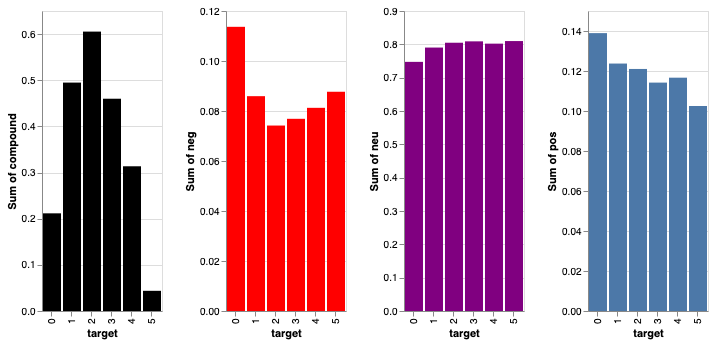

In [104]:
A = alt.Chart(sentiment_chart).mark_bar(color='black').encode(
    x='target:O',
    y='sum(compound):Q'
)

B = alt.Chart(sentiment_chart).mark_bar(color='red').encode(
    x='target:O',
    y='sum(neg):Q'
)

C = alt.Chart(sentiment_chart).mark_bar(color='purple').encode(
    x='target:O',
    y='sum(neu):Q'
)

D = alt.Chart(sentiment_chart).mark_bar().encode(
    x='target:O',
    y='sum(pos):Q'
)

A | B | C | D

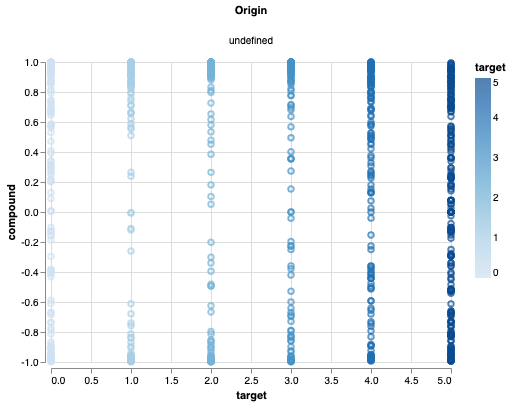

In [105]:
alt.Chart(df2).mark_point().encode(
    x='target',
    y='compound',
    color='target',
).facet(column='Origin:N')

# Naive Model 
<a id='Modeling'></a>

In [226]:
X = df['text']
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [227]:
cvec = CountVectorizer(stop_words='english',
                        lowercase=True,
                        ngram_range=(2, 2),
                        strip_accents='unicode')

tvec = TfidfVectorizer(stop_words='english',
                        ngram_range=(1, 3),
                        encoding='utf-8')

In [228]:
X_train_counts = cvec.fit_transform(X_train)
X_test_counts = cvec.transform(X_test)

In [229]:
df_counts = pd.DataFrame(X_train_counts.todense(), columns=cvec.get_feature_names())
df_counts.head()

,aadam aziz,abalone shell,abandon benefit,abandon intended,abandon pair,abandoned beach,abandoned evidence,abandoned framework,abandoned heroine,abandoned looked,...,zulu burmese,zulu evening,zulu impi,zulu manager,zulu people,zulu wish,zulu woman,zulu wot,zurich staring,zygote lost
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [230]:
model1 = LogisticRegression(solver='lbfgs', multi_class='multinomial')
model1.fit(X_train_counts, y_train)
y_pred = model1.predict(X_test_counts)
print(model1.score(X_train_counts, y_train))
print(model1.score(X_test_counts, y_test))

1.0
0.4818181818181818


In [231]:
def classification_metrics(y_test, y_pred):
    print(f' Accuracy Score: {accuracy_score(y_test, y_pred)}')
    print(f' Precision Score: {precision_score(y_test, y_pred, average = None)}')
    print(f' Recall Score: {recall_score(y_test, y_pred, average = None)}')
    
classification_metrics(y_test, y_pred)

 Accuracy Score: 0.4818181818181818
 Precision Score: [1.         1.         1.         1.         0.9        0.29113924]
 Recall Score: [0.38888889 0.08333333 0.28       0.375      0.5625     1.        ]


# Imbalance Learn with SMOTE

In [232]:
sm = SMOTE()
X_reb, y_reb = sm.fit_sample(X_train_counts, y_train)

model1.fit(X_reb, y_reb)
print(model1.score(X_reb, y_reb))
print(model1.score(X_test_counts, y_test))

0.8949864498644986
0.5181818181818182


In [233]:
y_pred = model1.predict(X_test_counts)


In [234]:
classification_metrics(y_test, y_pred)

 Accuracy Score: 0.5181818181818182
 Precision Score: [0.33962264 0.42857143 0.88888889 0.9        0.45       0.90909091]
 Recall Score: [1.         0.25       0.32       0.5625     0.5625     0.43478261]


# Regularization

In [235]:
model2 = LogisticRegression(C = 0.001,
                         class_weight = 'balanced',
                         multi_class = 'multinomial',
                         penalty= 'l2',
                         solver= 'sag')
model2.fit(X_reb, y_reb)
print(f'Train score: {model2.score(X_reb, y_reb)}')
print(f'Test score: {model2.score(X_test_counts, y_test)}')

Train score: 0.8252032520325203
Test score: 0.6363636363636364


In [236]:
y_pred = model2.predict(X_test_counts)

In [237]:
classification_metrics(y_test, y_pred)

 Accuracy Score: 0.6363636363636364
 Precision Score: [0.9        0.45454545 0.55882353 0.84615385 0.75       0.56666667]
 Recall Score: [0.5        0.41666667 0.76       0.6875     0.5625     0.73913043]


# Further Exploration of Preds

In [238]:
comparison = pd.DataFrame(y_pred, y_test)
comparison = comparison.reset_index()

In [239]:
comparison = comparison.rename(columns={0: 'prediction'})

In [240]:
comparison.head()

,target,prediction
0,0,5
1,3,2
2,0,0
3,4,4
4,3,2


In [241]:
comparison['prediction'] = comparison['prediction'].astype(int)

In [242]:
comparison['correct'] = np.where(comparison['target'] == comparison['prediction'], 1, 0)

In [243]:
comparison = comparison.rename(columns={0: 'prediction'})

In [244]:
comparison.target = comparison.target.astype(int)

In [245]:
comparison.head(5)

,target,prediction,correct
0,0,5,0
1,3,2,0
2,0,0,1
3,4,4,1
4,3,2,0


In [246]:
comparison.head()

,target,prediction,correct
0,0,5,0
1,3,2,0
2,0,0,1
3,4,4,1
4,3,2,0


In [247]:
comparison['difference'] = abs(comparison.target - comparison.prediction)

In [248]:
comparison.head()

,target,prediction,correct,difference
0,0,5,0,5
1,3,2,0,1
2,0,0,1,0
3,4,4,1,0
4,3,2,0,1


In [249]:
borderline_dates = len(comparison[comparison['difference'] <= 1]) / len(comparison['difference'])
borderline_dates

0.8181818181818182